In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from skimage.io import imread
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import IncrementalPCA
from sklearn_projects.image_processing.quickdraw.imagebuilder \
    import QuickDrawImageBuilder as ImageBuilder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import datasets, layers, models, Input, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model


from IPython.display import clear_output

# QuickDraw dataset GAN.

Let's try creating a generative adversarial network (GAN) for the QuickDraw dataset.
If successful, this will give us a model capable of "hallucinating" drawings based on the
training data available in the QuickDraw datasets.

Note this assumes you already have directories containing the .png image files
generated in `sklearn_projects/image_processing/quickdraw_analysis.ipynb`.

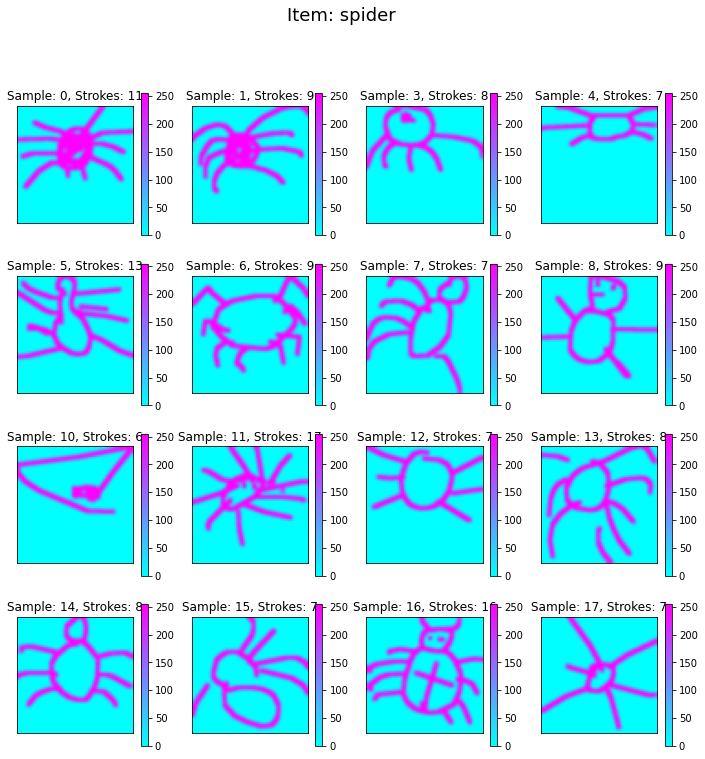

In [2]:
# pull in data and visualize
###############
data_names = ['spider']
path_to_data = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/'
###############

for data_name in data_names:

    # data location
    image_path = path_to_data + 'output_images/' + data_name + '/images/'

    # meta file
    meta_df = pd.read_csv(path_to_data + 'output_images/' + data_name + '/meta/meta.csv')
    # print(meta_df['recognized'].value_counts())

    # get image indices of recognized images:
    image_indices = meta_df[meta_df['recognized']==True]['sample_id'].values.tolist()

    plt.figure(figsize=(12,12))
    for plot_index, sample_id in enumerate(image_indices[:16]):
        sample = imread(image_path+'sample{}.png'.format(sample_id),
                        as_gray=True)
        plt.subplot(4,4,plot_index+1)
        plt.imshow(sample,
                   cmap='cool')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        num_strokes = meta_df[meta_df['sample_id'] == sample_id]['num_strokes'].values.tolist()[0]
        plt.title('Sample: {}, Strokes: {}'.format(sample_id, num_strokes))
    plt.suptitle('Item: {}'.format(data_name),
                 fontsize=18)
    plt.show();

In [3]:
# define input dataset
################
image_class = 'spider'
path_to_class_images = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/output_images/'
seed = 18210
val_split = 0.01
batch_size = 64
image_size = (64, 64)  # downsampling from original (256, 256) to speed training
################

# TODO: for gan, don't need a validation set... just put all in "training."

train_dataset = image_dataset_from_directory(directory=path_to_class_images + '{}/'.format(image_class),
                                             label_mode=None,
                                             seed=seed,
                                             validation_split=val_split,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             color_mode='grayscale',
                                             interpolation='area', # 'area'
                                             subset='training')

# ensure the max. pixel value in all input images is in [-1,1]
train_dataset = train_dataset.map(lambda x:
                                  tf.math.add(
                                      tf.math.scalar_mul(1./127.5, x),
                                      tf.math.scalar_mul(-1, tf.ones(shape=(image_size[0],image_size[1],1)))
                                  ))

val_dataset = image_dataset_from_directory(directory=path_to_class_images + '{}/'.format(image_class),
                                           label_mode=None,
                                           seed=seed,
                                           validation_split=val_split,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           color_mode='grayscale',
                                           interpolation='area',
                                           subset='validation')


Found 71849 files belonging to 2 classes.
Using 71131 files for training.
Found 71849 files belonging to 2 classes.
Using 718 files for validation.


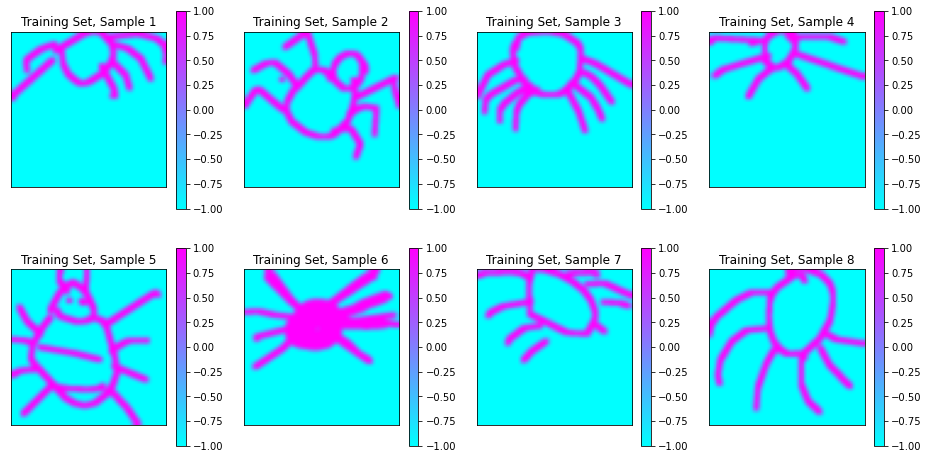

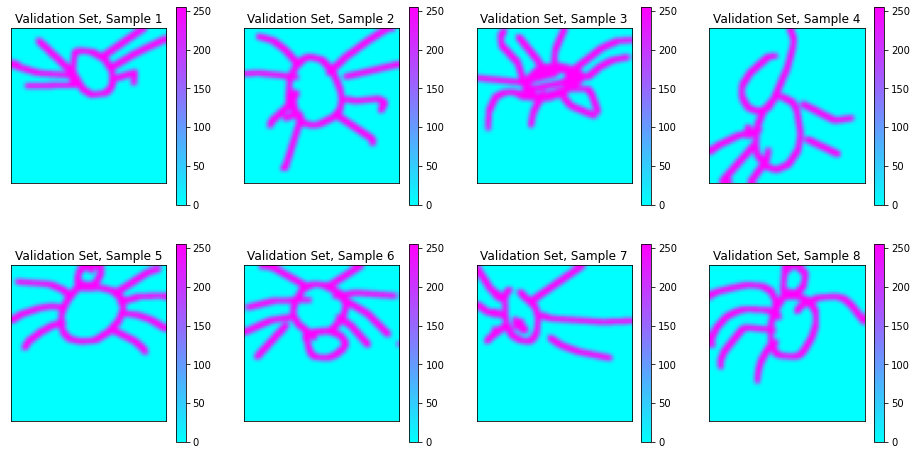

In [4]:
# viz. training data samples
dataset_names = ['Training', 'Validation']
for dataset_index, dataset in enumerate([train_dataset, val_dataset]):
    plt.figure(figsize = (16,8))
    for batch in dataset.take(1):
        for i in range(8):
            image = batch[i,:,:,0]
            plt.subplot(2, 4, i + 1)
            plt.imshow(image,
                       cmap='cool')
            plt.title('{} Set, Sample {}'.format(dataset_names[dataset_index],
                                                str(i+1)))
            plt.colorbar()
            plt.xticks([])
            plt.yticks([])

In [5]:
######################
# discriminator inputs
dropout_prob = 0.4
padding = 'same'
leakyrelu_alpha = 0.2   # recommended by Radford, Metz, and Chintala
######################

# define the discriminator network
def get_discriminator(image_input_shape=(256, 256, 1),
                      dropout_prob = 0.4,
                      padding = 'same',
                      leakyrelu_alpha = -1./5.5):
    """
    Build the discriminator model.

    This model takes as input an image, and outputs whether this image is
    a real or fake example from the target dataset.

    :param image_input_shape: the shape of the input image.
    :param dropout_prob: dropout probability. If 0, dropout layers will not be added.
    :param padding: type of padding for Conv2D and MaxPooling2D layers. Either 'same' or 'valid',
     defaults to 'same'.
    :return: model: the discriminator model.
    """

    # input
    image_input = Input(shape=image_input_shape)
    # x = Rescaling(scale=1./127.5, offset=1.)(image_input)  # rescale to [-1,1]

    # model
    #########
    # 1st conv. layer
    #########
    x = Conv2D(filters=64,
               kernel_size=(5, 5),
               strides=(2, 2),  # strided convolution rather than pooling layers
               padding=padding,
               kernel_initializer='glorot_normal')(image_input)
    # x = AveragePooling2D(pool_size=(2,2),
    #                      padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # 2nd conv. layer
    #########
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               strides=(2, 2),  # strided convolution rather than pooling layers
               padding=padding,
               kernel_initializer='glorot_normal')(x)
    # x = AveragePooling2D(pool_size=(2,2),
    #                      padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # 3rd conv. layer
    #########
    x = Conv2D(filters=16,
               kernel_size=(3, 3),
               strides=(2, 2),  # strided convolution rather than pooling layers
               padding=padding,
               kernel_initializer='glorot_normal')(x)
    # x = AveragePooling2D(pool_size=(2,2),
    #                      padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # output
    #########
    x = Flatten()(x)
    x = Dense(units=1,
              activation='sigmoid')(x)
    discriminator = Model(inputs=image_input,
                          outputs=x,
                          name='discriminator')

    return discriminator

discriminator = get_discriminator(image_input_shape=(image_size[0], image_size[1], 1),
                                  dropout_prob=dropout_prob,
                                  padding=padding,
                                  leakyrelu_alpha=leakyrelu_alpha)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)      

In [6]:
######################
# generator inputs
gen_input_shape = (100,)
padding = 'same'
batchnorm_momentum = 0.8
initial_depth = 60
initial_width = 8
leakyrelu_alpha = 0.2   # recommendeda by Radford, Metz, and Chintala
dropout_prob = 0.4
######################

# and build the generator model

def get_generator(gen_input_shape=(100,),
                  padding='same',
                  batchnorm_momentum=0.8,
                  initial_depth=256,
                  initial_width=11,
                  leakyrelu_alpha=-1./5.5,
                  dropout_prob=0.4):

    # input
    gen_input = Input(shape=gen_input_shape)

    # model
    ###########
    # build and shape tensor for inverse convolution
    ###########
    y = Dense(initial_depth*initial_width*initial_width)(gen_input)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    y = Reshape((initial_width, initial_width, initial_depth))(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 1st Conv2dTranspose
    ###########
    # y = Conv2DTranspose(filters=int(initial_depth/2),
    #                     kernel_size=(3, 3),
    #                     strides=(2,2),
    #                     padding=padding,
    #                     kernel_initializer='glorot_normal')(y)
    # y = BatchNormalization(momentum=batchnorm_momentum)(y)
    # y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    # if dropout_prob > 0:
    #     y = Dropout(dropout_prob)(y)
    ###########
    # 2nd Conv2dTranspose
    ###########
    y = Conv2DTranspose(filters=int(initial_depth/3),
                        kernel_size=(3, 3),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal')(y)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 3rd Conv2dTranspose
    ###########
    y = Conv2DTranspose(filters=int(initial_depth/6),
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal')(y)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 4th Conv2dTranspose
    ###########
    # y = Conv2DTranspose(filters=int(initial_depth/16),
    #                     kernel_size=(5, 5),
    #                     strides=(2, 2),
    #                     padding=padding,
    #                     kernel_initializer='glorot_normal')(y)
    # y = BatchNormalization(momentum=batchnorm_momentum)(y)
    # y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    # if dropout_prob > 0:
    #     y = Dropout(dropout_prob)(y)
    ##########
    # output
    ##########
    y = Conv2DTranspose(filters = 1,
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal',
                        activation='tanh')(y)
    generator = Model(inputs=gen_input,
                      outputs=y,
                      name='generator')

    return generator

generator = get_generator(gen_input_shape=gen_input_shape,
                          padding=padding,
                          batchnorm_momentum=batchnorm_momentum,
                          initial_depth=initial_depth,
                          initial_width=initial_width,
                          leakyrelu_alpha=leakyrelu_alpha,
                          dropout_prob=dropout_prob)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3840)              387840    
_________________________________________________________________
batch_normalization (BatchNo (None, 3840)              15360     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3840)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 60)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 60)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 20)        10

In [7]:
# define adversarial model
def get_adversarial(generator,
                    discriminator):
    adversarial = Sequential(name='adversarial')
    adversarial.add(generator)

    # only train generator layers
    for layer in discriminator.layers:
        layer.trainable = False
    adversarial.add(discriminator)

    # compile
    optimizer = keras.optimizers.Adam(learning_rate=0.0002,
                                      beta_1=0.5)  # b1 recommended by Radford, Metz, and Chintala
    adversarial.compile(loss='mean_squared_error',
                        optimizer=optimizer,
                        metrics=['mean_squared_error', 'mean_absolute_error'])

    return adversarial

# compile discriminator before adversarial, so weights can be frozen there
dis_optimizer = keras.optimizers.Adam(learning_rate=0.00002,
                                      beta_1=0.5)  # b1 recommended by Radford, Metz, and Chintala
discriminator.compile(loss='mean_squared_error',
                      optimizer=dis_optimizer,
                      metrics=['mean_squared_error', 'mean_absolute_error'])

adversarial = get_adversarial(generator,
                              discriminator)



adversarial.summary()

Model: "adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Functional)       (None, 64, 64, 1)         419401    
_________________________________________________________________
discriminator (Functional)   (None, 1)                 25777     
Total params: 445,178
Trainable params: 411,661
Non-trainable params: 33,517
_________________________________________________________________


In [8]:
# plot_model(adversarial)

## Training the GAN.

Stil experimental. Consider referencing the [work](https://github.com/soumith/ganhacks) of
S. Chintala, E. Denton, M. Arjovsky, and M. Mathieu. (I still haven't updated my naive model
with most of their recommendations... working on it!)

Tips from the reference that have been implemented:

1. **Normalize inputs** in [-1, 1], and use **tanh** as output activation for the generator.
2. Use **spherical noise**, that is noise drawn from Gaussian centered at 0 rather than a uniform
 distribution.
3. Use **noisy labels**, $y_{true} \in [0.085, 1.15]$ and $y_{gen} \in [-0.15, 0.15]$
 (uniform sampling).
4. Use **Average Pooling** for downsampling to avoid sparse gradients (and use LeakyReLU activations for this too).
 (Note, [another source](https://arxiv.org/abs/1511.06434) recommends using **strided convolution rather
  than a separate downsampling layer**, so the discriminator can learn its own downsampling functions. This is currently
  the version implemented.)
5. Use **Adam** optimizer for the generator, and use **SGD** for the discriminator. (Note: not sure why
 SGD is recommended for the discrminator... generally Adam has a better reputation?)
6. Train the discriminator using minibatches containing **only true** or **only fake** samples.
7. Add some (Gaussian) noise to the true training images to help stabilize learning.

Epoch: 2, Batch: 541
    Adv. Loss: 0.214747, Mean. Abs. Err: 0.457841.
    Dis. Loss: 0.298114, Mean. Abs. Err: 0.541789.
        Discrim. weight check: SHOULD CHANGE: -0.032063
        Discrim. weight check: SHOULD MATCH:  -0.032063
Traceback (most recent call last):
  File "D:\Conda\envs\gbreak\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-3adfce131d9e>", line 49, in <module>
    discrim_loss = discriminator.train_on_batch(x[batch_size:], y[batch_size:])
  File "D:\Conda\envs\gbreak\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1695, in train_on_batch
    logs = train_function(iterator)
  File "D:\Conda\envs\gbreak\lib\site-packages\tensorflow\python\eager\def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "D:\Conda\envs\gbreak\lib\site-packages\tensorflow\python\eager\def_function.py", line 807, in _call
    return sel

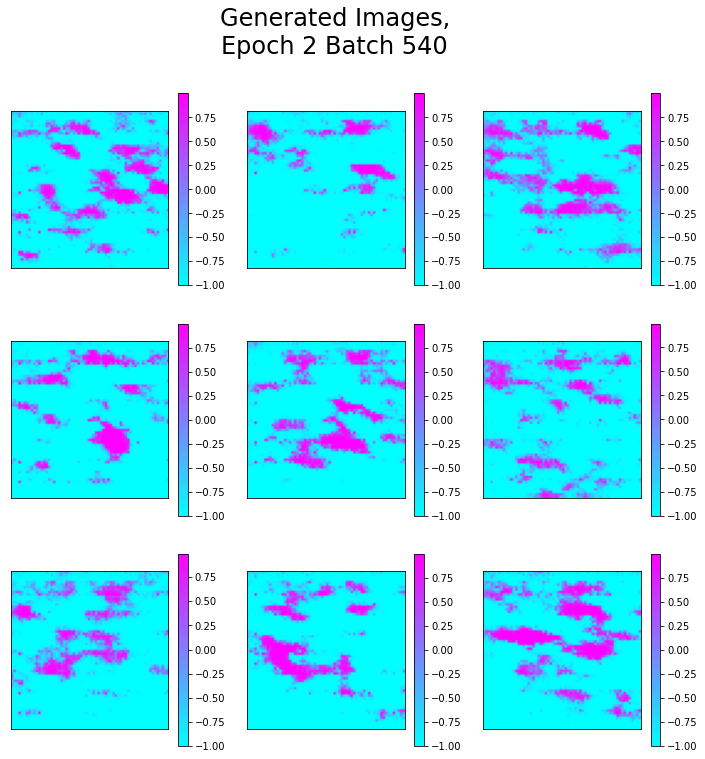

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: object of type 'NoneType' has no len()

In [8]:
# train the GAN!

##############
# inputs
train_steps = 10
batch_lim = 1000
##############

adv_losses = []
dis_losses = []
epoch = 0

# visualization
viz_noise = np.random.normal(0., 1., size=[9,
                                           gen_input_shape[0]])

for step in range(train_steps):
    epoch += 1
    batch_count = 0
    for batch in train_dataset.batch(batch_size=1,
                                     drop_remainder=True):
        batch_count += 1
        if batch_count > batch_lim:
            break
        noise = np.random.normal(0., 0.5, size=[batch_size,
                                               gen_input_shape[0]])
        true_images = batch[0,:,:,:,:]
        # add noise to help stabilize training (as recommended)
        img_noise = np.random.normal(0, 0.075, size=true_images.shape)
        true_images = true_images + img_noise

        # gen. fake images
        fake_images = generator.predict(noise)

        # build training data
        x = np.concatenate((true_images, fake_images))
        # y = np.ones([2*batch_size, 1])
        y = np.random.uniform(0.85,1.15,size=[2*batch_size, 1])  # noisy labels, 1 true, 0 fake
        y[batch_size:, :] = np.random.uniform(-0.1,0.1, size=[batch_size, 1]) # 1 true, 0 fake
        if batch_count == 1:
            print(y)

        # train discriminator

        # train on real
        discrim_loss = discriminator.train_on_batch(x[:batch_size], y[:batch_size])
        # dis_losses += [discrim_loss]
        # train on fake
        discrim_loss = discriminator.train_on_batch(x[batch_size:], y[batch_size:])

        # get adversarial data (generated only)
        noise = np.random.normal(0., 0.5, size=[batch_size,
                                               gen_input_shape[0]])
        # y = np.ones([batch_size, 1])
        y = np.random.uniform(0.9,1.1, size=[batch_size, 1])  # noisy labels, 1 = true (trying to fool discrim)
        if batch_count == 1:
            print(y)

        # train adversarial (generator and discriminator)
        adv_loss = adversarial.train_on_batch(noise, y)
        # adv_losses += [adv_loss]
        # if step%5 == 0:
        if batch_count%20 == 0:
            clear_output(wait=True)
            print('Epoch: {}, Batch: {}'.format(step+1, batch_count+1))
            print('    Adv. Loss: {:.6f}, Mean. Abs. Err: {:.6f}.'.format(adv_loss[0], adv_loss[2]))
            print('    Dis. Loss: {:.6f}, Mean. Abs. Err: {:.6f}.'.format(discrim_loss[0], discrim_loss[2]))
            print('        Discrim. weight check: SHOULD CHANGE: {:.6f}'.format(discriminator.layers[1].get_weights()[0][0,0,0,0]))
            print('        Discrim. weight check: SHOULD MATCH:  {:.6f}'.format(np.array(adversarial.layers[1].get_weights()[0])[0,0,0,0]))
            plt.figure(10,
                       figsize=(12, 12))
            viz_images = generator.predict(viz_noise)
            for viz_image in range(viz_images.shape[0]):
                plt.subplot(3, 3, viz_image + 1)
                plt.imshow(viz_images[viz_image,:,:,0],
                           cmap='cool')
                plt.xticks([])
                plt.yticks([])
                plt.colorbar()
            plt.suptitle('Generated Images,\nEpoch {} Batch {}'.format(epoch, batch_count),
                         fontsize=24)
            plt.show()


In [ ]:
plotting = True
for batch in train_dataset.batch(batch_size=1,
                                 drop_remainder=True):
    true_images = batch[0,:,:,:,:]
    # print(true_images.shape)
    img_noise = np.random.normal(0,0.25,size=true_images.shape)
    true_images = true_images + img_noise
    if plotting:
        plt.figure(figsize=(16,16))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.imshow(true_images[i,:,:,0])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        plotting = False
        break


## Hard lessons:

1. The first inverse convolutional layer of the generator should have channels of sufficient width (>8 pixels),
 or the results won't have enough "expressiveness." That is, outputs will have a tiled/quilted structure.